# Fractal Dimension Computation

## Chris Tralie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

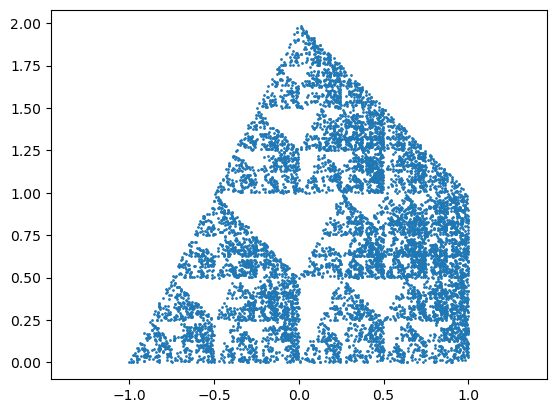

In [2]:
# Create a Sierpinski simplex using the "chaos game" method
pts = np.array([[-1, 0, 0], [1, 0, 0], [0, 2, 0], [1, 1, 1]])
n_points = 10000

np.random.seed(0)
p = np.array(pts[0, :])
X = []
for i in range(n_points):
    idx = np.random.randint(pts.shape[0])
    p = 0.5*(p + pts[idx, :])
    X.append(p)

X = np.array(X)
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.axis("equal");

# Persistent H0-Based Dimension

In [3]:
def get_h0_total(X, alpha):
    """
    Compute the total persistence in H0 by quickly computing the 
    MST as a subset of the Delaunay complex
    
    Parameters
    ----------
    X: ndarray(N, d)
        Point cloud
    alpha: float
        Power to weight each edge length
    
    Returns
    -------
    float: Power weighted total persistence sum
    """
    from scipy import sparse
    from scipy.spatial import Delaunay
    from itertools import combinations

    N = X.shape[0]
    simplices = Delaunay(X).simplices
    I = np.array([])
    J = np.array([])
    V = np.array([])
    counts = np.array([])

    ## Step 1: Compute distances of all edges in the Delaunay complex
    for (i, j) in combinations(range(simplices.shape[1]), 2):
        Ik = simplices[:, i]
        Jk = simplices[:, j]
        Vk = np.sqrt(np.sum((X[Ik, :] - X[Jk, :])**2, axis=1))
        I = np.concatenate((I, Ik))
        J = np.concatenate((J, Jk))
        V = np.concatenate((V, Vk))
        counts = np.concatenate((counts, np.ones(Ik.size)))
    Ds = sparse.coo_matrix((V, (I, J)), shape=(N, N))
    counts = sparse.coo_matrix((counts, (I, J)), shape=(N, N))
    Ds = Ds/counts
    
    ## Step 2: Compute the minimum spanning tree to get H0
    tree = sparse.csgraph.minimum_spanning_tree(Ds)
    ds = np.array(tree[tree.nonzero()]).flatten()
    return np.sum(ds**alpha)
    
def get_h0_fractaldim(X, alpha=0.5, samples=100):
    """
    Compute the H0-based fractal dimension, according to the procedure in [1]
    
    [1] Fractal Dimension Estimation with Persistent Homology: A Comparative Study
    Jonathan Jaquette and Benjamin Schweinhart
    
    Parameters
    ----------
    X: ndarray(N, d)
        Point cloud
    alpha: float
        Power to weight each edge length
    
    Returns
    -------
    float: Fractal dimension estimate
    """
    from scipy.stats import linregress
    N = X.shape[0]
    Ns = 10**np.linspace(np.log10(N/10), np.log10(N), 100)
    Ns = np.array(np.floor(Ns), dtype=int)
    Es = []
    for n in Ns:
        Xn = X[np.random.permutation(N)[0:n], :]
        En = get_h0_total(Xn, alpha)
        Es.append(En)
    beta = linregress(np.log(Ns), np.log(Es)).slope
    return alpha/(1-beta)

tic = time.time()
print(get_h0_fractaldim(X))
toc = time.time()
print("Elapsed Time: {:.3f}".format(toc-tic))

1.9992707190925112
Elapsed Time: 52.498


In [4]:
# Ground truth sierpinski triangle dimension is 1.585, sierpinski tetrahedron dimension is 2

# 1.593085374169665
# 1.5877226790702332
# 1.5874764799379697


# Correlation Dimension

In [5]:
def find_dist_thresh(X, n_target, tree=None, eps_initial=1e-3, n_iters=10, verbose=False):
    """
    Find the distance threshold at which n edges exist, using
    Golden sections search
    
    Parameters
    ----------
    X: ndarray(N, d)
        Point cloud
    n_target: int
        Target number of points
    tree: scipy.spatial.KDTree
        KDTree, if precomputed
    eps_initial: float
        Epsilon at which to start searching for interval endpoints
    n_inters: int
        Number of iterations of golden sections
    verbose: bool
        If true, print golden section search iterations
    
    Returns
    -------
    float: Epsilon value that gets close to n_target
    """
    from scipy.spatial import KDTree
    N = X.shape[0]
    if not tree:
        tree = KDTree(X)
    get_n = lambda eps: np.sum(tree.query_ball_point(X, eps, return_length=True))-N
    
    ## Step 1: Figure out interval endpoints
    a = eps_initial
    n_est = get_n(a)
    while n_est > n_target:
        a /= 2
        n_est = get_n(a)
    b = a
    while n_est < n_target:
        b *= 2
        n_est = get_n(b)
    
    ## Step 2: Run golden sections search
    gr = (np.sqrt(5) + 1)/2
    f = lambda eps: np.abs(get_n(eps)-n_target)
    c = b - (b - a)/gr
    d = a + (b - a)/gr
    for i in range(n_iters):
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b - a)/gr
        d = a + (b - a)/gr
        eps = (b + a)/2
        if verbose:
            print(eps, get_n(eps))
        if get_n(eps) == n_target:
            break
    return eps
    
def get_correlation_dimension(X, n_samples=100):
    """
    Compute the correlation dimension for fractal estimation
    
    Parameters
    ----------
    X: ndarray(N, d)
        Point cloud
    n_samples: int
        Number of distance thresholds to take in the estimation
    """
    from scipy.stats import linregress
    from scipy.spatial import KDTree
    N = X.shape[0]
    tree = KDTree(X)
    n1 = N**0.75
    n2 = 50*N

    eps1 = find_dist_thresh(X, n1, tree=tree)
    eps2 = find_dist_thresh(X, n2, tree=tree)
    all_eps = 2**np.linspace(np.log2(eps1), np.log2(eps2), n_samples)
    
    
    get_n = lambda eps: np.sum(tree.query_ball_point(X, eps, return_length=True))-N
    C = [get_n(eps) for eps in all_eps]    

    return linregress(np.log(all_eps), np.log(C)).slope

tic = time.time()
print(get_correlation_dimension(X))
toc = time.time()
print("Elapsed Time: {:.3f}".format(toc-tic))

1.9949018431373788
Elapsed Time: 1.946
